In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
from flax.linen.initializers import ones
from bnn_functions import *
rng_key = jax.random.key(int(date.today().strftime("%Y%m%d")))

In [2]:
target = "SPY"
SPY_daily = yf.download(target)
full_df = SPY_daily
full_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.840683,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.017351,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.070353,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.335375,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.441374,531500
...,...,...,...,...,...,...
2024-02-16,501.700012,502.869995,498.750000,499.510010,499.510010,75461200
2024-02-20,497.720001,498.410004,494.450012,496.760010,496.760010,71736700
2024-02-21,495.420013,497.369995,493.559998,497.209991,497.209991,59603800


In [3]:
errors=full_df.isna().any(axis=1)
errors[errors==True]

Series([], dtype: bool)

In [4]:
def create_lagged_columns(df, n, target):
    for i in range(1, n + 1):
        df[f"{target}_lag_{i}"] = df[target].shift(i)
    return df

def get_Daily_Volatility(close,span0=20):
    # simple percentage returns
    df0=close.pct_change()
    # 20 days, a month EWM's std as boundary
    df0=df0.ewm(span=span0).std()
    df0.dropna(inplace=True)
    return df0

def yfinance_labeler(df, hold_period, upper_lower_multipliers):
    vol_df = get_Daily_Volatility(df.Close)
    df = df.reindex(vol_df.index)
    prices = df["Close"]
    labels = []

    for row in range(0,len(vol_df)):
        if ((len(vol_df)-row) - hold_period) > 0:
            upper_bound = prices[row] + prices[row] * upper_lower_multipliers[0] * vol_df[row]
            lower_bound = prices[row] - prices[row] * upper_lower_multipliers[1] * vol_df[row]
            
            pot_bucket = np.array(list(prices[row+1: row+1+hold_period]))
            index_up_min = None
            index_low_min = None

            if (pot_bucket>=upper_bound).any():
                index_up_min = np.argmax(pot_bucket>=upper_bound)
            if (pot_bucket<=lower_bound).any():
                index_low_min = np.argmax(pot_bucket<=lower_bound)

            if (index_up_min is not None) & (index_low_min is not None):
                if index_up_min<index_low_min:
                    labels.append(1)
                else:
                    labels.append(0)
            elif index_up_min is not None:
                labels.append(1)
            elif index_low_min is not None:
                labels.append(0)
            else:
                labels.append(0) #hier könnte das dritte label stehen
        else:
            labels.append(12)
    print(len(labels))
    df["vola"] = vol_df
    df["label"] = labels

    df_output = df[df["label"] != 12]
    return(df_output)

In [5]:
investment_horizon = 10
bound_volas = [2, 1.5]

full_df = yfinance_labeler(full_df, investment_horizon, bound_volas)
full_df

7821


,Open,High,Low,Close,Adj Close,Volume,vola,label
Date,,,,,,,,
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.070353,201300,0.003531,1
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.335375,529400,0.004342,0
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.441374,531500,0.003702,0
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.423727,492100,0.004477,0
1993-02-08,44.968750,45.125000,44.906250,44.968750,25.423727,596100,0.004363,0
...,...,...,...,...,...,...,...,...
2024-02-02,489.649994,496.049988,489.299988,494.350006,494.350006,99147700,0.008208,0
2024-02-05,493.700012,494.380005,490.230011,492.549988,492.549988,75757100,0.008027,1
2024-02-06,493.519989,494.320007,492.049988,493.980011,493.980011,55918600,0.007640,1


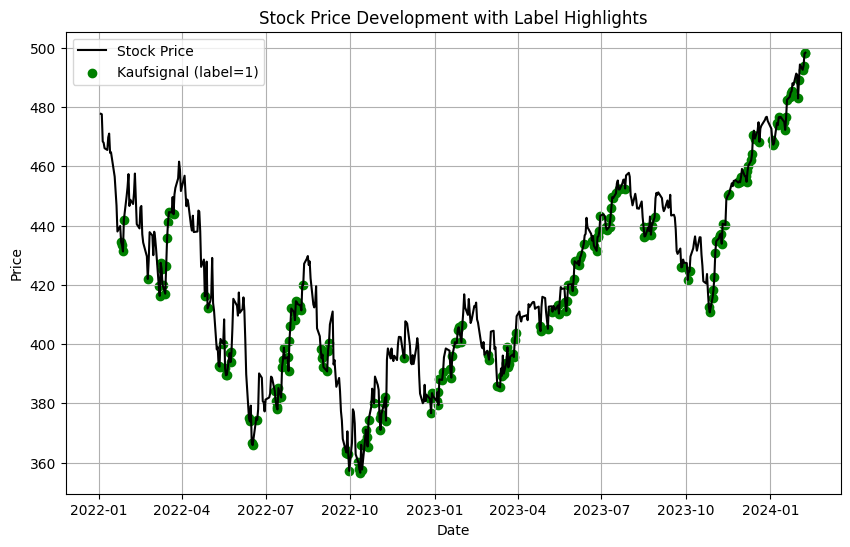

In [6]:
plot_df = full_df["2022-01-01":]

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[plot_df['label'] == 1].index, plot_df[plot_df['label'] == 1]['Close'], color='green', label='Kaufsignal (label=1)')

# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [7]:
nine_period_high = full_df['High'].rolling(window= 9).max()
nine_period_low = full_df['Low'].rolling(window= 9).min()
tenkan_sen = (nine_period_high + nine_period_low) /2
full_df['tenkan_sen_perc'] = tenkan_sen.pct_change(1)
# Kijun-sen (Base Line): (26-period high + 26-period low)/2))
period26_high = full_df['High'].rolling(window=26).max()
period26_low = full_df['Low'].rolling(window=26).min()
kijun_sen = (period26_high + period26_low) / 2
full_df['kijun_sen_perc'] = kijun_sen.pct_change(1)
# Senkou Span A (Leading Span A): (Conversion Line + Base Line)/2))
senkou_span_a = ((tenkan_sen + kijun_sen) / 2).shift(26)
full_df['senkou_span_a_perc'] = senkou_span_a.pct_change(1)
# Senkou Span B (Leading Span B): (52-period high + 52-period low)/2))
period52_high = full_df['High'].rolling(window=52).max()
period52_low = full_df['Low'].rolling(window=52).min()
senkou_span_b = ((period52_high + period52_low) / 2).shift(26)
full_df['senkou_span_b_perc'] = senkou_span_b.pct_change(1)

var_list = [tenkan_sen, kijun_sen, senkou_span_a, senkou_span_b]
names_list = ["tenkan_sen", "kijun_sen", "senkou_span_a", "senkou_span_b"]
for var, name in zip(var_list,names_list):
    colname = name+"_higher_close"
    full_df[colname] = [1 if a > b else 0 for a, b in zip(var, list(full_df["Close"]))]
    
full_df["tenkan_sen_higher_kijun_sen"] = [1 if a > b else 0 for a, b in zip(tenkan_sen, kijun_sen)]
full_df["tenkan_sen_kijun_sen_DIFF"] = tenkan_sen - kijun_sen

full_df["senkou_span_a_higher_senkou_span_b"] = [1 if a > b else 0 for a, b in zip(senkou_span_a, senkou_span_b)]
full_df["senkou_span_a_senkou_span_b_DIFF"] = senkou_span_a - senkou_span_b

full_df["tenkan_sen_higher_cloud"] = [1 if a > b else 0 for a, b in zip(tenkan_sen, [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)])]
full_df["kijun_sen_higher_cloud"] = [1 if a > b else 0 for a, b in zip(kijun_sen, [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)])]

full_df["tenkan_sen_cloudDIFF"] = tenkan_sen - [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)]
full_df["kijun_sen_cloudDIFF"] = kijun_sen - [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)]

full_df["positive_crossover"] = [1 if x >= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] < 0 else 0 for i, x in enumerate(full_df["tenkan_sen_kijun_sen_DIFF"])]
full_df["crossover"] = [1 if (x >= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] < 0) or (x <= 0 and full_df["tenkan_sen_kijun_sen_DIFF"][i - 1] > 0) else 0 for i, x in enumerate(full_df["tenkan_sen_kijun_sen_DIFF"])]

crossover_above = []
for val1, val2, val3 in zip([min(c, d) for c, d in zip(tenkan_sen, kijun_sen)], [max(c, d) for c, d in zip(senkou_span_a, senkou_span_b)], full_df["crossover"]):
    if val3 == 1 and val1 > val2:
        crossover_above.append(1)
    else:
        crossover_above.append(0)

full_df["crossover_above"] = crossover_above

crossover_below = []
for val1, val2, val3 in zip([min(c, d) for c, d in zip(tenkan_sen, kijun_sen)], [min(c, d) for c, d in zip(senkou_span_a, senkou_span_b)], full_df["crossover"]):
    if val3 == 1 and val1 < val2:
        crossover_below.append(1)
    else:
        crossover_below.append(0)

full_df["crossover_below"] = crossover_below

full_df["positive_crossover_cloud"] = [1 if x >= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] < 0 else 0 for i, x in enumerate(full_df["senkou_span_a_senkou_span_b_DIFF"])]
full_df["crossover_cloud"] = [1 if (x >= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] < 0) or (x <= 0 and full_df["senkou_span_a_senkou_span_b_DIFF"][i - 1] > 0) else 0 for i, x in enumerate(full_df["senkou_span_a_senkou_span_b_DIFF"])]

full_df

,Open,High,Low,Close,Adj Close,Volume,vola,label,tenkan_sen_perc,kijun_sen_perc,...,tenkan_sen_higher_cloud,kijun_sen_higher_cloud,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.070353,201300,0.003531,1,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.335375,529400,0.004342,0,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.441374,531500,0.003702,0,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1993-02-05,44.968750,45.062500,44.718750,44.968750,25.423727,492100,0.004477,0,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
1993-02-08,44.968750,45.125000,44.906250,44.968750,25.423727,596100,0.004363,0,NaN,NaN,...,0,0,NaN,NaN,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,489.649994,496.049988,489.299988,494.350006,494.350006,99147700,0.008208,0,0.004628,0.004624,...,1,1,22.812492,14.597496,0,0,0,0,0,0
2024-02-05,493.700012,494.380005,490.230011,492.549988,492.549988,75757100,0.008027,1,0.000000,0.000000,...,1,1,21.637489,13.422493,0,0,0,0,0,0
2024-02-06,493.519989,494.320007,492.049988,493.980011,493.980011,55918600,0.007640,1,0.000000,0.000000,...,1,1,20.832497,12.617500,0,0,0,0,0,0


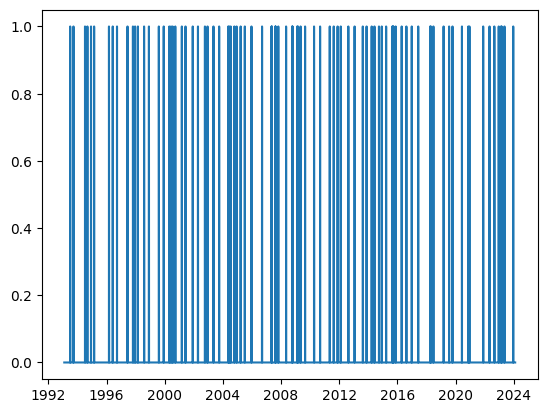

In [8]:
plt.plot(full_df.index, full_df['positive_crossover_cloud'])

In [9]:
full_df['close_pct'] = full_df['Close'].pct_change(1)
full_df['Volume_pct'] = full_df['Volume'].pct_change(1)

In [10]:
full_df.drop(['Open', 'Close', 'High', 'Low', 'Adj Close', 'Volume'], axis=1, inplace=True)

In [11]:
# for col in list(full_df.columns):
#     full_df=create_lagged_columns(full_df, 20, col)

In [12]:
full_df

,vola,label,tenkan_sen_perc,kijun_sen_perc,senkou_span_a_perc,senkou_span_b_perc,tenkan_sen_higher_close,kijun_sen_higher_close,senkou_span_a_higher_close,senkou_span_b_higher_close,...,tenkan_sen_cloudDIFF,kijun_sen_cloudDIFF,positive_crossover,crossover,crossover_above,crossover_below,positive_crossover_cloud,crossover_cloud,close_pct,Volume_pct
Date,,,,,,,,,,,,,,,,,,,,,
1993-02-02,0.003531,1,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,NaN,NaN
1993-02-03,0.004342,0,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.010571,1.629906
1993-02-04,0.003702,0,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.004184,0.003967
1993-02-05,0.004477,0,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,-0.000694,-0.074130
1993-02-08,0.004363,0,NaN,NaN,NaN,NaN,0,0,0,0,...,NaN,NaN,0,0,0,0,0,0,0.000000,0.211339
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-02,0.008208,0,0.004628,0.004624,0.003252,0.000768,0,0,0,0,...,22.812492,14.597496,0,0,0,0,0,0,0.010527,0.078964
2024-02-05,0.008027,1,0.000000,0.000000,0.002518,0.000090,0,0,0,0,...,21.637489,13.422493,0,0,0,0,0,0,-0.003641,-0.235917
2024-02-06,0.007640,1,0.000000,0.000000,0.001721,0.001005,0,0,0,0,...,20.832497,12.617500,0,0,0,0,0,0,0.002903,-0.261870


In [13]:
test_begin = "2018-01-01"
full_df.dropna(inplace=True)
train_df = full_df[:test_begin]
test_df = full_df[test_begin:]

In [14]:
Xs_train = train_df.drop('label', axis=1).values
Xs_test = test_df.drop('label', axis=1).values
Ys_train = train_df['label'].values
Ys_test = test_df['label'].values

In [15]:
# MLP params
hidden_layer_width = 5
n_hidden_layers = 5

class NN(nn.Module):
    n_hidden_layers: int
    layer_width: int

    @nn.compact
    def __call__(self, x):
        for i in range(self.n_hidden_layers):
            x = nn.Dense(features=self.layer_width)(x)
            x = nn.tanh(x)
        return nn.Dense(features=1)(x)


bnn = NN(n_hidden_layers, hidden_layer_width)

In [16]:
# probabilities_train = final_model.predict_proba(X_full)
# probabilities_train_positive = probabilities_train[:, 1]

# #Create a Precision/Recall curve for our training data
# precision_train, recall_train, pr_thresholds_train = precision_recall_curve(y_full, probabilities_train_positive)
# fscore_train = 2 * (precision_train * recall_train) / (precision_train + recall_train)

# #Find optimal thresh on PR curve train
# ix = np.argmax(fscore_train)
# optimal_threshold = pr_thresholds_train[ix]

In [17]:
rng_key, eval_key = jax.random.split(rng_key)


def fit_and_eval_single_mlp(key, X_train, Y_train, X_test):
    return fit_and_eval(
        key, bnn, logdensity_fn_of_bnn, X_train, Y_train, X_test, grid= None, num_samples=600,batch_size_particles = 50, batch_size_data = 64, num_particles=1000
    )

Ys_pred_train, Ys_pred_test, _ = fit_and_eval_single_mlp(eval_key, Xs_train, Ys_train, Xs_test)

100%|██████████| 600/600 [03:21<00:00,  2.97it/s]


0.4
0.43400002


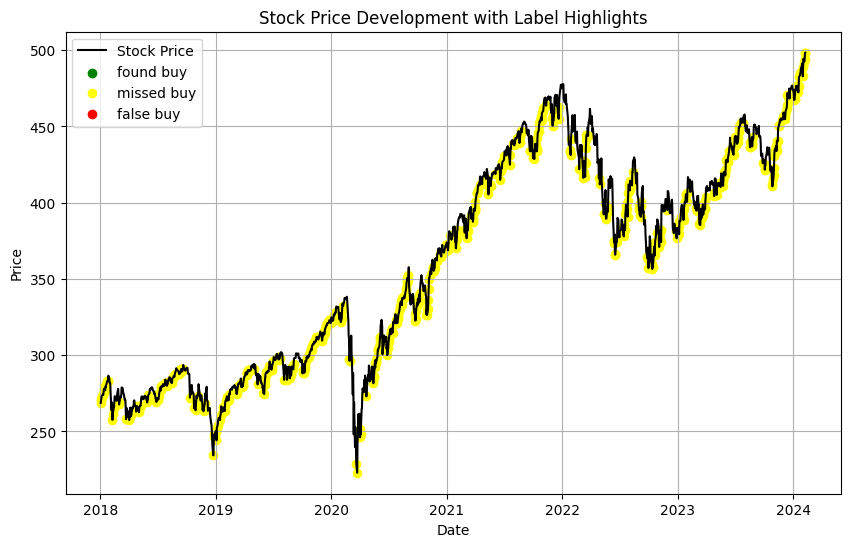

In [18]:
# Add Close prices back to df to see the visualization
prices = SPY_daily[test_begin:]["Close"]
plot_df = test_df.copy()
plot_df["Close"] = prices
plot_df["signal"] = Ys_pred_test.astype(int)

plt.figure(figsize=(10, 6))
plt.plot(plot_df.index, plot_df['Close'], label='Stock Price', color='black')

# Highlight points where 'label' is 1 in green
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 1)]['Close'], color='green', label='found buy')
plt.scatter(plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)].index, plot_df[(plot_df['label'] == 1) & (plot_df['signal'] == 0)]['Close'], color='yellow', label='missed buy')
plt.scatter(plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)].index, plot_df[(plot_df['label'] == 0) & (plot_df['signal'] == 1)]['Close'], color='red', label='false buy')


# Customize the plot
plt.title('Stock Price Development with Label Highlights')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

In [19]:
print(f"Train accuracy = {100 * jnp.mean(Ys_pred_train == Ys_train):.2f}%")
print(f"Test accuracy = {100 * jnp.mean(Ys_pred_test == Ys_test):.2f}%")

Train accuracy = 58.80%
Test accuracy = 56.38%
